<a href="https://colab.research.google.com/github/Feru34/Modelos_Toronbolo/blob/main/k_Nearest_Neighbor_and_Clustering_k_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementción k-Nearest Neighbor y Clustering k-Means AI Computer Society

Integrantes:
- Felipe Rueda
- Johan Suarez

Fuente de los datos: https://www.kaggle.com/code/samuelcortinhas/k-nearest-neighbours-knn-from-scratch/notebook

# k-Nearest Neighbor

El algoritmo **K-Nearest Neighbors (KNN)** es un método de aprendizaje supervisado utilizado tanto para clasificación como para regresión. Es un algoritmo basado en instancias, lo que significa que no tiene una etapa de entrenamiento como otros algoritmos, sino que toma decisiones basadas en los datos directamente.

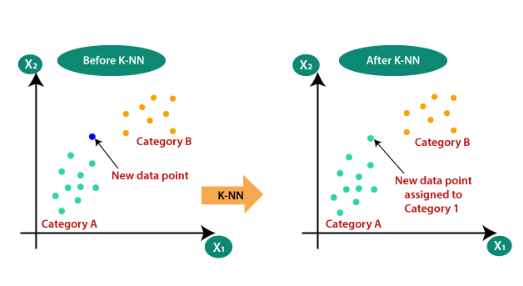


En este cuaderno, motivaremos e implementaremos el algoritmo de k-Vecinos Más Cercanos (kNN) desde cero.

Este código configura el entorno para análisis de datos y visualización:

1. **NumPy (`np`)**: Para cálculos numéricos eficientes.
2. **Pandas (`pd`)**: Para manipulación de datos tabulares.
3. **Seaborn (`sns`)**: Para visualizaciones estadísticas con estilo personalizado.
4. **Matplotlib (`plt`)**: Para crear gráficos; `%matplotlib inline` muestra gráficos en el notebook.
5. **`train_test_split`**: Divide los datos en conjuntos de entrenamiento y prueba (de scikit-learn).
6. **Scipy.stats**: Proporciona herramientas estadísticas avanzadas.

Todo esto es esencial para análisis, modelado y visualización de datos.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from scipy import stats
import time

Aplicaremos el algoritmo kNN en el famoso conjunto de datos de cáncer de mama de UCI. Este es un problema de clasificación binaria cuyo objetivo es predecir si un paciente tiene cáncer de mama o no, utilizando varias características extraídas de imágenes.

In [ ]:
# Load data
data = pd.read_csv('data.csv', index_col='id').reset_index(drop=True)
data.drop('Unnamed: 32', axis=1, inplace=True)

# Preview data
print('Dataframe shape:', data.shape)
data.head(3)

Dataframe shape: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Acontinuación vamos a :
1. **Separar datos:**
   - `X`: Contiene las características (todas las columnas excepto `diagnosis`).
   - `y`: Contiene las etiquetas (`diagnosis`).

2. **Codificar etiquetas:**
   - Convierte `y` en valores binarios: `1` si es maligno (`M`), `0` si es benigno.

In [ ]:
# Features and labels
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Encode target to binary
y = (y=='M').astype('int')

In [ ]:
# Split dataset into training and testing data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Conceptos Clave de KNN:
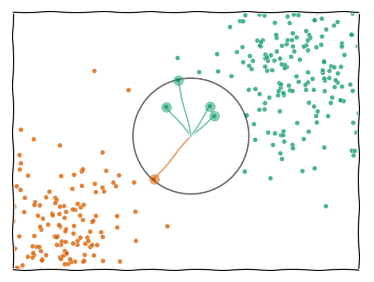
1. **Funcionamiento Básico:**
   - Cuando se recibe un dato nuevo para clasificar o predecir, el algoritmo:
     1. Calcula la distancia entre el nuevo dato y todos los datos existentes en el conjunto de entrenamiento. Las distancias más comunes son:
        - **Euclidiana** (la más usada)
        - Manhattan
        - Coseno

        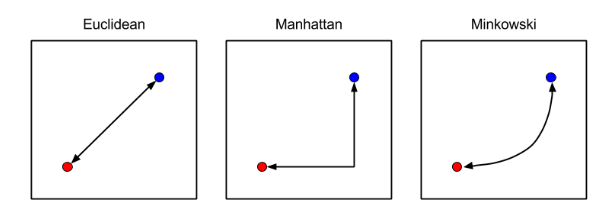
     2. Identifica los **K vecinos más cercanos** según estas distancias.
     3. Realiza una decisión basada en los datos vecinos:
        - **Clasificación:** Se asigna la clase más frecuente entre los vecinos (votación por mayoría).
        - **Regresión:** Se calcula el promedio de los valores objetivo de los vecinos.

2. **Parámetro K:**
   - Es el número de vecinos que el algoritmo considera.
   - Si \(K\) es pequeño, el modelo puede ser sensible al ruido (sobreajuste).
   - Si \(K\) es grande, el modelo puede suavizar demasiado y perder precisión (subajuste).




A continuación, se implementa una clase personalizada `kNN` para el algoritmo de k-Vecinos Más Cercanos:

1. **Inicialización:** Configura el número de vecinos `k`, la métrica de distancia (euclidiana, Manhattan o Minkowski) y parámetros opcionales.
2. **Funciones de distancia:** Calcula distancias entre puntos según la métrica elegida.
3. **`fit`:** Almacena los datos de entrenamiento y etiquetas.
4. **`predict`:** Predice clases para puntos de prueba buscando los `k` vecinos más cercanos y seleccionando la clase mayoritaria.
5. **`get_neighbours`:** Calcula distancias, ordena y selecciona los `k` vecinos más cercanos.

**Propósito:** Implementar kNN desde cero con soporte para múltiples métricas de distancia.

In [ ]:
class kNN():
    '''k-Nearest Neighbours'''
    # Initialise
    def __init__(self, k=3, metric='euclidean', p=None):
        self.k = k
        self.metric = metric
        self.p = p

    # Euclidean distance (l2 norm)
    def euclidean(self, v1, v2):
        return np.sqrt(np.sum((v1-v2)**2))

    # Manhattan distance (l1 norm)
    def manhattan(self, v1, v2):
        return np.sum(np.abs(v1-v2))

    # Minkowski distance (lp norm)
    def minkowski(self, v1, v2, p=2):
        return np.sum(np.abs(v1-v2)**p)**(1/p)

    # Store train set
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Make predictions
    def predict(self, X_test):
        preds = []
        # Loop over rows in test set
        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            majority = stats.mode(nearest_neighbours, keepdims=True).mode[0]

            preds.append(majority)
        return np.array(preds)

    # Get nearest neighbours
    def get_neighbours(self, test_row):
        distances = list()

        # Calculate distance to all points in X_train
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            if self.metric=='euclidean':
                dist = self.euclidean(train_row, test_row)
            elif self.metric=='manhattan':
                dist = self.manhattan(train_row, test_row)
            elif self.metric=='minkowski':
                dist = self.minkowski(train_row, test_row, self.p)
            else:
                raise NameError('Supported metrics are euclidean, manhattan and minkowski')
            distances.append((dist, train_class))

        # Sort distances
        distances.sort(key=lambda x: x[0])

        # Identify k nearest neighbours
        neighbours = list()
        for i in range(self.k):
            neighbours.append(distances[i][1])

        return neighbours

1. **Calcular precisión:**  
   La función `accuracy` mide el porcentaje de predicciones correctas comparando `preds` con `y_test`.

2. **Probar kNN con diferentes métricas:**  
   - Para cada métrica (`euclidean` y `manhattan`):
     - Se inicializa un modelo `kNN` con `k=5` y la métrica correspondiente.
     - El modelo se entrena con los datos de entrenamiento (`fit`).
     - Se realizan predicciones sobre los datos de prueba (`predict`).
     - Se imprime la precisión calculada para cada métrica.

**Propósito:** Comparar el rendimiento del algoritmo kNN usando distintas métricas de distancia.

In [ ]:
#  Function to calculate accuracy
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()

# Apply our kNN algorithm
for metric in ['euclidean', 'manhattan']:
    clf = kNN(k=5, metric=metric)
    clf.fit(X_train.values, y_train.values)
    preds = clf.predict(X_test.values)
    print(f'Metric: {metric}, accuracy: {accuracy(preds, y_test):.3f} %')

Metric: euclidean, accuracy: 87.719 %
Metric: manhattan, accuracy: 91.228 %


## Resultados

Haremos una matriz de confusión en los siguientes pasos:
1. **Importar herramientas:**  
   - `confusion_matrix`: Genera la matriz de confusión, que muestra el rendimiento del modelo al clasificar las etiquetas.

2. **Aplicar kNN con distintas métricas:**  
   - Para cada métrica (`euclidean` y `manhattan`), se entrena el modelo `kNN` y se obtienen las predicciones.

3. **Generar matriz de confusión:**  
   - Compara las etiquetas reales (`y_test`) con las predicciones (`preds`).
   - Imprime la matriz de confusión, que indica:
     - Verdaderos positivos (TP)
     - Verdaderos negativos (TN)
     - Falsos positivos (FP)
     - Falsos negativos (FN)

**Propósito:** Evaluar cómo se distribuyen los aciertos y errores de clasificación para cada métrica de distancia.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener matriz de confusión
for metric in ['euclidean', 'manhattan']:
    clf = kNN(k=5, metric=metric)
    clf.fit(X_train.values, y_train.values)
    preds = clf.predict(X_test.values)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    print(f"Metric: {metric}")
    print("Confusion Matrix:")
    print(cm)


Metric: euclidean
Confusion Matrix:
[[71  9]
 [ 5 29]]
Metric: manhattan
Confusion Matrix:
[[75  5]
 [ 5 29]]


El **Classification Report** ofrece un resumen detallado del rendimiento de un modelo de clasificación utilizando las siguientes métricas clave:
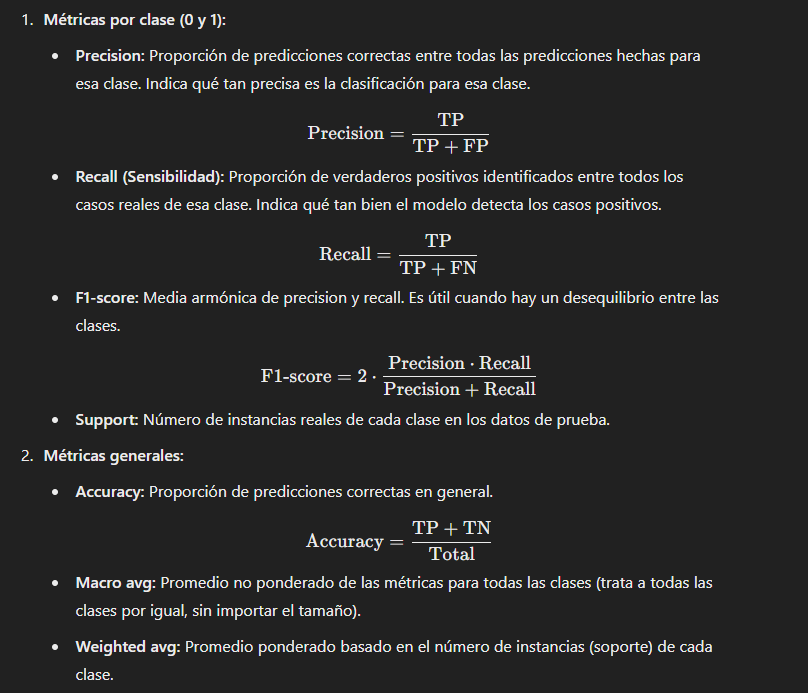

**Uso:**  
Estas métricas ayudan a comprender el rendimiento del modelo en términos de precisión, sensibilidad y balance entre las clases, especialmente útil en casos con datos desbalanceados.

In [ ]:
    # Reporte de clasificación
    print("Classification Report:")
    print(classification_report(y_test, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        80
           1       0.85      0.85      0.85        34

    accuracy                           0.91       114
   macro avg       0.90      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



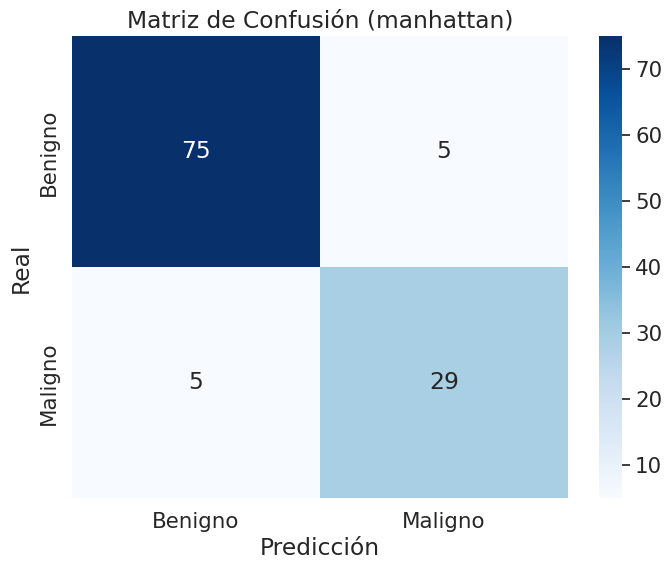

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title(f"Matriz de Confusión ({metric})")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Conclusiones:

1. **Rendimiento general:** El modelo tiene un **91% de precisión global**, con un buen equilibrio entre precisión y sensibilidad.

2. **Clase 0 (negativos):** Excelente rendimiento (F1-score: 94%), detecta y clasifica correctamente la mayoría de los casos negativos.

3. **Clase 1 (positivos):** Buen desempeño (F1-score: 85%), pero podría mejorarse para reducir falsos negativos si son críticos.

4. **Recomendación:** Ajustar el modelo (umbral o balance de clases) si la prioridad es maximizar la detección de positivos.

 **Ventajas de KNN:**
   - Simplicidad: Fácil de entender e implementar.
   - No necesita entrenamiento explícito: Al ser un algoritmo basado en instancias, utiliza directamente los datos.

 **Desventajas de KNN:**
   - Computacionalmente intensivo: A medida que aumenta el tamaño del conjunto de datos, el cálculo de distancias puede ser costoso.
   - Dependencia de la escala: Los resultados pueden variar según la escala de las variables; por ello, es importante normalizar o estandarizar los datos.
   - Sensible a la elección de \(K\) y a los datos desbalanceados (por ejemplo, si una clase domina).

# Clustering k-Means